# Final Project Report

* Class: DS 5100
* Student Name: Efrain Olivares
* Student Net ID: dpy8wq
* This URL: https://github.com/Niarfe/DS5100_project/blob/main/DS51200_FinalProjectTemplate.ipynb

# Instructions

Follow the instructions in the Final Project isntructions notebook and put evidence of your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL:  https://github.com/Niarfe/DS5100_project

Paste a copyy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

```python
"""
Montecarlo module

Contains the main classes to play the montecarlo simulation

Die        Simulated die/card-deck
Game       Simulates rolling the die and capturing results
Analyzer   Provides analytics on the results of a game object

Please see the help strings for the classes/methods for more details
"""
import pandas as pd
import numpy as np

class Analyzer:
    """
    Inspect a played Game object and extract results

    Initializer arguments:
        game           Game object which has been played

    METHODS            RETURNS
    jackpot            int, A count of times the die all returned the same face
    face_counts        dataframe, Counts of how many times each face came up in the rolls
    combo_count        dataframe, Counts of how many combinations (non-ordered) came up
    permuation_count   dataframe, Counts of how many combinations, ordered, came up.

    For more details please see the help() on each of the methods
    """
    def __init__(self, game):
        """
        Extracts measurements from a played game for analysis

        INPUT:
            game        Game, a Game object that has been been played
        """
        if not isinstance(game, Game):
            raise ValueError("game should be of type Game")
        self.game = game
        self.df = self.game.show()

    def jackpot(self):
        """
        Calculate how many rolls of the dies in a Game object hit a jackpot.

        A jackpot is defined as a roll where all the die came up with the same face.

        INPUT:
            None
        RETURNS:
            int, the number of jackpots found in all the rolls.
        """
        return int((self.df.nunique(axis=1) == 1).sum())


    def face_counts(self):
        """
        Calculate how many times a face came up during the play

        INPUT:
            None
        RETURNS:
           pd.DataFrame, with
        """
        df_counts = self.df.apply(pd.Series.value_counts, axis=1)
        df_counts = df_counts.fillna(0)
        df_counts.index.name = 'roll'
        return df_counts

    def combo_count(self):
        """
        Calculate the different combinations from a game of dice

        A combination is order independent, so ABC is the same as BCA, CAB etc.

        INPUT:
            None
        RETURNS:
            pd.DataFrame  containing a multi index for the face values and column with
                              the counts
        """
        df_combo = self.df.apply(lambda x: tuple(sorted(x)), axis=1)
        df_count = df_combo.value_counts().to_frame(name='count')
        df_count.index = pd.MultiIndex.from_tuples(df_count.index)
        return df_count

    def permutation_count(self):
        """
        Calculate the different combinations from a game of dice

        A permutation is order dependent, so ABC is NOT the same as BCA, CAB etc.
            Each order dependent combination has it's own count

        Permutations are stored as a strung together set of values.  For example,
        a set of resulting faces ['W', 'O', 'R', 'D'] is reported as permutation 'WORD' 

        INPUT:
            None
        RETURNS:
            pd.DataFrame  containing a multi index for the permutations and column with the counts
        """
        df_perms = self.df.apply(lambda x: "".join(list(x)), axis=1)
        df_perms = df_perms.value_counts().to_frame()
        df_perms.index.name = 'perm'
        return df_perms


class Game:
    """
    Simulates game play by 'rolling' a set of dice

    There are two main methods:
        play     Rolls the set of dice a given number of times and stores all the results
                    in a pandas dataframe

        show     Returns the pandas dataframe with the current state of play
    """
    def __init__(self, dice):
        """
        INPUT:
            dice     list<Die>, a list of dice all configured with the same face values
        """
        assert isinstance(dice, list)
        assert isinstance(dice[0], Die)
        self.dice = dice
        self._rolls = None

    def play(self, nroll):
        """
        Iterates through the list of dice and 'rolls' them a given number of N times.

        INPUT:
            nroll    int, the number of times to roll the set of dice
        RETURNS:
            pd.DataFrame    Contains one row per roll, where each roll has the roll number
                                and the resulting faces per roll
        """
        assert isinstance(nroll, int)
        results = {}
        for idx, die in enumerate(self.dice):
            results[idx] = die.roll(nroll)

        self._rolls = pd.DataFrame(results)
        return self._rolls


    def show(self, display='wide'):
        """
        Returns the internal state of results from a roll in either plain format or
            a wide format (stacked)

        INPUT:
            display    string, 'wide' for standard format, 'narrow' for stacked
        RETURNS:
            pd.DataFrame    The dataframe in the format specfied
        """
        if display not in ['narrow', 'wide']:
            raise ValueError(f"Unrecognized display format {display}")

        if display == 'wide':
            return self._rolls.copy()

        tmp_frame = self._rolls.stack().to_frame(name='results')
        tmp_frame.index.names = ['roll', 'die']
        return tmp_frame


class Die:
    """
    Stores a set of faces and weights representing a die, deck of cards or other
        'rollable'.  Rollable meaning that one face will be 'up' after one roll.
        The initial state is for all faces to have a default weight of 1.
        Weights can be updated to make a particular face 'heavier' by altering it's weight.
        Thereafter when a die is rolled, the weighed face has a higher chance of coming 'up'

    Note that when a die is rolled it's internal structure is not altered.  It simply
        returns a list of faces that came up.  It's internal state, (faces, weights)
        remains the same.
    """
    def __init__(self, faces):
        """
        Intanciates a die from a given set of faces representing a die

        INPUT:
            faces    np.array, a numpy array containing strings or numbers for the die faces
                        e.g. faces = np.array(['heads', 'tails'], dtype='object')

        NOTE: The face values must be unique.  I.e. ['heads', 'heads', tails'] rould result
                   in an exception thrown when creating a die

        """
        assert isinstance(faces, np.ndarray)
        assert len(faces) == len(np.unique(faces)), "faces array must be unique"
        self.weights = np.array([1.0]*len(faces), dtype=int)
        self.die = pd.DataFrame({
            'faces': faces,
            'weights': self.weights
            })


    def update_weight(self, side, weight):
        """
        Modify the default weights (1.0) of a face

        INPUTS:
            side     string, the face to be modified
            weight   float,  the new weight to be associated with the face
        """
        if side not in self.die['faces'].values:
            raise IndexError(f"The face {side} does not exist in the die")


        if not isinstance(weight, int):
            raise TypeError(f"Expected np.long for weight but got {type(weight)}")

        self.die.loc[self.die.faces == side, 'weights'] = weight


    def roll(self, ntimes=1):
        """
        'Roll' the dice specified number of times (default 1)

        INPUTS:
            ntimes   int, the number of times to roll the die
        RETURNS:
            list, a list contining the face result for each time the die was rolled
        """
        return np.random.choice(
                self.die['faces'],
                size=ntimes,
                replace=True,
                p=self.die['weights'] / self.die['weights'].sum()
                ).tolist()


    def get_state(self):
        """
        Access the internal state of the die stored in a pd.DataFrame
        
        INPUTS:
            None

        RETURNS:
            pd.DataFrame   self.die, the internal dataframe holding the face values and weights            
        """
        return self.die
```

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

```python
import sys
sys.path.append('.')
import random
import unittest
import numpy as np
import pandas as pd
from montecarlo.montecarlo import Die, Game, Analyzer


class AnalyzerTestSuite(unittest.TestCase):
    def setUp(self):
        faces = np.array(['heads', 'tails'], dtype='object')
        self.dice = [Die(faces), Die(faces)]
        self.game = Game(self.dice)
        self.game.play(1000)
        self.analyzer = Analyzer(self.game)


    def test_initializer(self):
        """
        Given an initialized Analyzer object 
        When I check it's internal game variable and check what type of object it is
        Then I should find it is of type Game
        """
        self.assertIsInstance(self.analyzer.game, Game, "Analyzer's game variable should be of type Game")

    def test_jackpot(self):
        """
        Given an Analyzer object intialized with a played Game with two coins
          And the coins have equal weights
          And it has been played with 1000 rolls
        When I request the number of jackpots
        Then the jackpot function should return an int
          And I should find that the number of jackpots should be approximately 50%

        NOTE:  With two dice, there are four outcomes per roll, two of which give you the jackpot.
                   heads/heads and tails/tails.  So that's 2 out of 4, or 50%
        """
        num_jackpots = self.analyzer.jackpot() 
        self.assertIsInstance(num_jackpots, int, "Analyzer jackpot should return an int")
        self.assertAlmostEqual(num_jackpots/1000, 0.5, None, "With two coins, prob of jackpit is 1/2", 0.1)

    def test_face_counts(self):
        """
        Given an Analyzer object intialized with a played Game with two coins
          And the coins have equal weights
          And it has been played with 1000 rolls
        When I request the fact counts
          And take the sum of the tails
        Then the face_counts method should return a pd.DataFrame
          And the number of tails should be aproximately 50%
        """
        df = self.analyzer.face_counts()
        self.assertIsInstance(df, pd.DataFrame, "Analyzer face_counts should return a pandas dataframe")
        self.assertAlmostEqual(int(df['tails'].sum()/1000), 0.9, None, "Given fair dice, about half the faces should be tails", 0.1)

    def test_combo_count(self):
        """
        Given an Analyzer object intialized with a played Game with two coins
          And the coins have equal weights
          And it has been played with 1000 rolls
        When I request the combo counts
          And take the sum of the ('heads','tails') combination
        Then the combo_counts method should return a pd.DataFrame
          And the number of ('heads',, 'tails') should be aproximately 50%
        """
        df = self.analyzer.combo_count()
        self.assertIsInstance(df, pd.DataFrame)
        self.assertAlmostEqual(df.loc[('heads', 'tails')]['count'].sum()/1000, 0.5, None, "With two coins combination 'heads', 'tails' is should be about 1/2", 0.05)

    def test_perm_count(self):
        """
        Given an Analyzer object intialized with a played Game with two coins
          And the coins have equal weights
          And it has been played with 1000 rolls
        When I request the permutation counts
          And take the sum of the 'tailstails' permutation 
        Then the perm_counts method should return a pd.DataFrame
          And the number of 'tailstails' should be aproximately 25%
        """
        df = self.analyzer.permutation_count()
        self.assertIsInstance(df, pd.DataFrame)
        self.assertAlmostEqual(df.loc['tailstails']['count'].sum()/1000, 0.25, None, "With two coins the permutation shoudl be about 1/4 ", 0.05)



class GameTestSuite(unittest.TestCase):
    def setUp(self):
        faces = np.array(['heads', 'tails'], dtype='object')
        self.dice = [Die(faces), Die(faces)]
        self.game = Game(self.dice)

    def test_initializer(self):
        """
        Given an Game object intialized with two coins
        When I check the type of the dice
        Then the type should match 'list'
        """
        self.assertTrue(isinstance(self.game.dice, list))


    def test_play(self):
        """
        Given an Game object intialized with two coins
          And I roll it 5 times
        When I check the type of the results
        Then I should find the type of the result is a pd.DataFrame
        """
        results = self.game.play(5)
        self.assertTrue(isinstance(results, pd.DataFrame))
    
    def test_play_length(self):
        """
        Given an Game object intialized with two coins
          And I roll it 5 times
        When I check the type of the results
        Then I should find the length of the dataframe to be 5 
        """
        results = self.game.play(5)
        self.assertEqual(len(results), 5)

    def test_show(self):
        """
        Given an Game object intialized with two coins
        When I roll the die once
        Then I should find the result of the play to be of type pd.DataFrame
        """
        df = self.game.play(1)
        self.assertIsInstance(df, pd.DataFrame)


class DieTestSuite(unittest.TestCase):
    def setUp(self):
        face_list = ['heads', 'tails']
        faces = np.array(face_list, dtype='object')
        self.die = Die(faces)

    def test_load_faces(self):
        """
        Given a die initalized with a coin (two faces 'heads', 'tails')
        When I check for the face values and weights
        Then I should find
          one heads face
          one tails face
          two 1.0 weights
        """
        self.assertTrue('heads' in self.die.die['faces'].values)
        self.assertTrue('tails' in self.die.die['faces'].values)
        weights = self.die.die['weights'].to_list()
        self.assertEqual(weights.count(1.0), 2)


    def test_get_state(self):
        """
        Given a die initalized with a coin (two faces 'heads', 'tails')
        When I call the get_state method 
        Then I should find that the type returned is a pd.DataFrame 
        """
        die_table = self.die.get_state()

        assert isinstance(die_table, pd.DataFrame)


    def test_bad_face_update_weight(self):
        """
        Given a die initalized with a coin (two faces 'heads', 'tails')
        When I update one of the weights with a non-existing face 
        Then I should find the method returns an IndexError
          And a message indicting the face was not fund
        """
        with self.assertRaises(IndexError) as context:
            self.die.update_weight('edge', 2)

        self.assertTrue("The face edge does not exist in the die" in str(context.exception))


    def test_bad_weight_update_weight(self):
        """
        Given a die initalized with a coin (two faces 'heads', 'tails')
        When I update one of the weights with a non-valid weight (not a number type) 
        Then I should find the method returns a TypeError
          And gives a message stating it got the wrong type for weight
        """
        with self.assertRaises(TypeError) as context:
            self.die.update_weight('heads', 'double')

        self.assertTrue("Expected np.long for weight but got <class 'str'>" in str(context.exception))


    def test_roll_fair(self):
        """
        Given a die initalized with a coin (two faces 'heads', 'tails')
        When I roll the die 1000 times
          And I check the fraction of times heads comes up
        Then I should find the fraction to be approximately 50%
        """
        result_faces = self.die.roll(1000)
        fraction_heads = result_faces.count('heads')/1000

        self.assertAlmostEqual(fraction_heads, 0.5, None, "With 1:1 we should se about 50% heads", 0.05)


    def test_roll_loaded(self):
        """
        Given a die initalized with a coin (two faces 'heads', 'tails')
          And I set one of the dice to a weight of 2 (default 1)
        When I roll the dice 1000 times
          And I check the fraction of times heads comes up
        Then I should find the fraction to be approximately 66%
        """
        self.die.update_weight('heads', 2)
        result_faces = self.die.roll(1000)
        fraction_heads = result_faces.count('heads')/1000

        self.assertAlmostEqual(fraction_heads, 0.66, None, "With 1:2 we should se about 66% heads", 0.05)

if __name__=="__main__":
    unittest.main(verbosity=3)
```

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

In [24]:
! make test

clear
pytest -v tests/test_montecarlo.py
============================= test session starts ==============================
platform darwin -- Python 3.12.5, pytest-8.3.5, pluggy-1.5.0 -- /Users/praedator/Documents/UVA/MSDS/DS5100_project/env/bin/python3.12
cachedir: .pytest_cache
rootdir: /Users/praedator/Documents/UVA/MSDS/DS5100_project
plugins: anyio-4.9.0
collected 15 items                                                             

tests/test_montecarlo.py::AnalyzerTestSuite::test_combo_count PASSED     [  6%]
tests/test_montecarlo.py::AnalyzerTestSuite::test_face_counts PASSED     [ 13%]
tests/test_montecarlo.py::AnalyzerTestSuite::test_initializer PASSED     [ 20%]
tests/test_montecarlo.py::AnalyzerTestSuite::test_jackpot PASSED         [ 26%]
tests/test_montecarlo.py::AnalyzerTestSuite::test_perm_count PASSED      [ 33%]
tests/test_montecarlo.py::GameTestSuite::test_initializer PASSED         [ 40%]
tests/test_montecarlo.py::GameTestSuite::test_play PASSED                [ 46%

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [3]:
import montecarlo.montecarlo

## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [4]:
help(montecarlo)

Help on package montecarlo:

NAME
    montecarlo - Montecarlo Game Simulation

DESCRIPTION
    This package simulates a montecarlo dice roll game.

    There are three classes in the package, Die, Game and Analyzer.

    Basic Flow:
        * Create a numpy array(s) of text or numerical symbols.
        * Create a list of Die objects by passing the symbols.
        * Pass this list to a Game object
        * 'play' using the Game object to run the simulation.
        * Pass the Game object to an Analyzer
        * Inspect several aspects of the outcome.

    Some notes:
    * You can also create 'weighed' dice by using the Game's update_weight function.
    * The faces for a set of Die should be the same, however, you can use any
           combination for a set of die.  For example:
               - ['1', '2','3', '4', '5', '6'] # a standard die
               - ['a', 'b', 'c', .... 'z']     # crabble like play
               - ['ace-hearts', 'two-hearts', ... 'king-spades'] # a deck 

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL: https://github.com/Niarfe/DS5100_project/blob/main/README.md

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

```bash
(env) ~/ttttt efrain $ pip list
Package Version
------- -------
pip     25.1
(env) ~/ttttt efrain $ cat requirements.txt
git+https://github.com/Niarfe/DS5100_project.git
(env) ~/ttttt efrain $ pip install -r requirements.txt
Collecting git+https://github.com/Niarfe/DS5100_project.git (from -r requirements.txt (line 1))
  Cloning https://github.com/Niarfe/DS5100_project.git to /private/var/folders/pv/7plgkmrn0s97wqdtn_70hcmw0000gp/T/pip-req-build-zlh0lhkq
  Running command git clone --filter=blob:none --quiet https://github.com/Niarfe/DS5100_project.git /private/var/folders/pv/7plgkmrn0s97wqdtn_70hcmw0000gp/T/pip-req-build-zlh0lhkq
  Resolved https://github.com/Niarfe/DS5100_project.git to commit 1ea48bb0fdc52515947dff3e28c577898321287b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Collecting pandas (from montecarlo==0.1->-r requirements.txt (line 1))
  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
Collecting numpy (from montecarlo==0.1->-r requirements.txt (line 1))
  Using cached numpy-2.2.5-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
Collecting python-dateutil>=2.8.2 (from pandas->montecarlo==0.1->-r requirements.txt (line 1))
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
Collecting pytz>=2020.1 (from pandas->montecarlo==0.1->-r requirements.txt (line 1))
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
Collecting tzdata>=2022.7 (from pandas->montecarlo==0.1->-r requirements.txt (line 1))
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Collecting six>=1.5 (from python-dateutil>=2.8.2->pandas->montecarlo==0.1->-r requirements.txt (line 1))
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached numpy-2.2.5-cp312-cp312-macosx_14_0_arm64.whl (5.2 MB)
Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl (11.4 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Building wheels for collected packages: montecarlo
  Building wheel for montecarlo (pyproject.toml) ... done
  Created wheel for montecarlo: filename=montecarlo-0.1-py3-none-any.whl size=4603 sha256=99364b9d9b497379fd1d4c4275fc60575bcef9f3a30b45cc7e2aaa738ad980ed
  Stored in directory: /private/var/folders/pv/7plgkmrn0s97wqdtn_70hcmw0000gp/T/pip-ephem-wheel-cache-uzhi_vqs/wheels/cf/4d/77/fe88bc27db0442efdc8e1690d39314f498bbd1e37633926e25
Successfully built montecarlo
Installing collected packages: pytz, tzdata, six, numpy, python-dateutil, pandas, montecarlo
Successfully installed montecarlo-0.1 numpy-2.2.5 pandas-2.2.3 python-dateutil-2.9.0.post0 pytz-2025.2 six-1.17.0 tzdata-2025.2
```

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [5]:
from montecarlo.montecarlo import Die, Game, Analyzer
import numpy as np

In [6]:
fair_coin = Die(np.array(['H','T'], dtype='object'))
unfair_coin = Die(np.array(['H','T'], dtype='object'))
unfair_coin.update_weight('T', 5)

Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [7]:
game_ff = Game([fair_coin, fair_coin])
game_ff.play(1000)

,0,1
0,T,T
1,H,H
2,H,T
3,T,H
4,H,H
...,...,...
995,H,H
996,T,T
997,T,H
998,T,T


Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [8]:
game_uuf = Game([unfair_coin, unfair_coin, fair_coin])
game_uuf.play(1000)

,0,1,2
0,T,T,H
1,T,T,T
2,T,T,T
3,T,T,T
4,T,T,H
...,...,...,...
995,T,T,T
996,T,T,H
997,T,H,T
998,T,H,H


Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [9]:
analyze_ff = Analyzer(game_ff)
f_ff = analyze_ff.jackpot()
print(f"Frequency of fair coin jackpots is {f_ff} per 1000")
analyze_uuf = Analyzer(game_uuf)
f_uuf = analyze_uuf.jackpot()
print(f"Frequency of 2 unfair plus 1 fair coin jackpots is {f_uuf} per 1000")

Frequency of fair coin jackpots is 501 per 1000
Frequency of 2 unfair plus 1 fair coin jackpots is 387 per 1000


Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [10]:
rel_f_ff = f_ff/1000
rel_f_uuf = f_uuf/1000
print(f"Relative frequencies of fair and unfair set {rel_f_ff}:{rel_f_uuf}")

Relative frequencies of fair and unfair set 0.501:0.387


Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

<Axes: xlabel='game'>

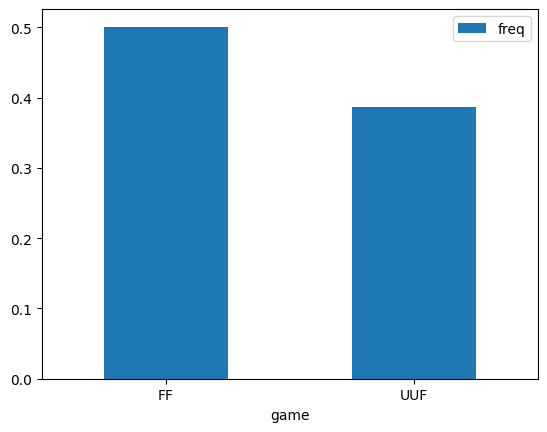

In [11]:
import pandas as pd
df = pd.DataFrame({'game':['FF', 'UUF'], 'freq':[rel_f_ff, rel_f_uuf]})
df.plot.bar(x='game', y='freq', rot=0)

## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [12]:
dice1 = Die(np.array(['1','2','3','4','5','6'], dtype='object'))
dice2 = Die(np.array(['1','2','3','4','5','6'], dtype='object'))
dice3 = Die(np.array(['1','2','3','4','5','6'], dtype='object'))

Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [13]:
dice1.update_weight('6', 5)

Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [14]:
dice2.update_weight('1', 5)

Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [15]:
game3 = Game([dice1, dice2, dice3])
game3.play(10000)

,0,1,2
0,3,1,5
1,2,1,3
2,4,1,3
3,3,2,1
4,6,4,2
...,...,...,...
9995,1,5,1
9996,6,5,6
9997,4,1,3
9998,2,1,2


Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [16]:
dice4 = Die(np.array(['1','2','3','4','5','6'], dtype='object'))
dice5 = Die(np.array(['1','2','3','4','5','6'], dtype='object'))
game5 = Game([dice1, dice2, dice3, dice4, dice5])
game5.play(10000)

,0,1,2,3,4
0,4,5,3,2,3
1,3,2,2,1,6
2,6,3,3,4,1
3,6,4,4,4,6
4,3,2,2,1,4
...,...,...,...,...,...
9995,5,6,5,1,5
9996,3,1,5,3,2
9997,4,3,6,5,4
9998,6,2,4,2,2


Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

<Axes: xlabel='game'>

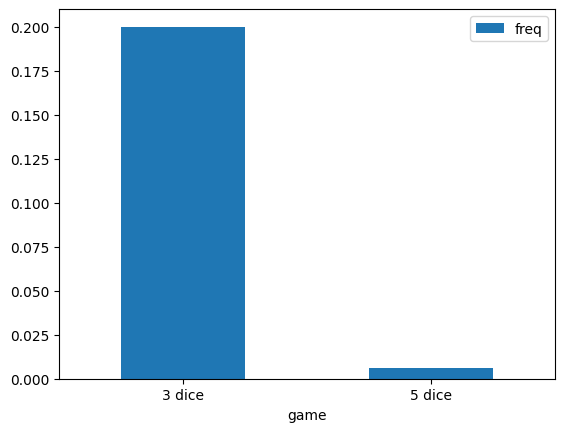

In [17]:
analyze_game3 = Analyzer(game3)
analyze_game5 = Analyzer(game5)
rel_f_game3 = analyze_game3.jackpot()/1000
rel_f_game5 = analyze_game5.jackpot()/1000
df = pd.DataFrame({'game':['3 dice', '5 dice'], 'freq':[rel_f_game3, rel_f_game5]})
df.plot.bar(x='game', y='freq', rot=0)

## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [18]:
letters = []
weights = []

# Load the file into letters and weights lists
for letter_line in open('data/english_letters.txt', 'r').readlines():
    letters.append(letter_line.split()[0].strip())
    weights.append(int(letter_line.split()[1].strip()))

# Create the dice
dice = [Die(np.array(letters, dtype='object'))]*4

# Update weights on the dice
for die in dice:
    [die.update_weight(let, wei) for let, wei in zip(letters, weights)]

Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [19]:
scrabble_game = Game(dice)
scrabble_game.play(1000)

,0,1,2,3
0,R,C,D,Y
1,H,D,R,I
2,D,H,E,L
3,T,N,L,A
4,T,B,N,I
...,...,...,...,...
995,G,R,I,T
996,L,G,N,A
997,N,N,T,T
998,S,T,P,N


Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [20]:
ana_scrabble = Analyzer(scrabble_game)
df_words = ana_scrabble.permutation_count()
scrabble_words = {word.strip() for word in open('data/scrabble_words.txt', 'r').readlines()}
set_words = set(df_words.index.to_list())
scrabble_words.intersection(set_words)

{'ACTS',
 'AGUE',
 'ALMS',
 'ANTA',
 'AWDL',
 'BREE',
 'CAVE',
 'CRON',
 'DADO',
 'DORT',
 'ESES',
 'FERE',
 'FROG',
 'GOAL',
 'GRIT',
 'HENT',
 'LAST',
 'LATE',
 'LINY',
 'MELA',
 'NEON',
 'NODE',
 'NOMA',
 'NONA',
 'NOSH',
 'NOWT',
 'PAIS',
 'PATY',
 'PHEW',
 'POLL',
 'RIDE',
 'RIPS',
 'ROHE',
 'SASS',
 'SAYS',
 'SCAM',
 'SENS',
 'SHAN',
 'SLIM',
 'SNEE',
 'SNOT',
 'SWIG',
 'TEND',
 'TINE',
 'TOED',
 'TUFA',
 'UNDO',
 'UPON',
 'VAES',
 'VOES',
 'WEAR',
 'WERT'}

Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [21]:
# Create the dice
dice = [Die(np.array(letters, dtype='object'))]*5

# Update weights on the dice
for die in dice:
    [die.update_weight(let, wei) for let, wei in zip(letters, weights)]

# Step 2
scrabble_game = Game(dice)
scrabble_game.play(1000)

# Step 3
ana_scrabble = Analyzer(scrabble_game)
df_words = ana_scrabble.permutation_count()
set_words = set(df_words.index.to_list())
scrabble_words.intersection(set_words)

{'HOMOS', 'MISGO'}

# Conclusion
Running with 5 dice drastically reduces the number of matched words from ROUGHLY 10, to 1.  A 10:1 ratio between using 4:5 letters